In [ ]:
import zipfile
import os, glob
import numpy as np
import nibabel as nib
from nibabel.processing import resample_from_to
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [1]:
def unzip_to_folder(zip_path):
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    os.makedirs(folder_name, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print(f"Unzipped {zip_path} → {folder_name}/")
    return folder_name

In [2]:
unzip_to_folder("/content/Data_nii_final.zip")

✔ Unzipped /content/Data_nii_final.zip → Data_nii_final/


'Data_nii_final'

In [3]:
unzip_to_folder("/content/Final_Dataset.zip")

✔ Unzipped /content/Final_Dataset.zip → Final_Dataset/


'Final_Dataset'

In [ ]:
unzip_to_folder("/content/Label.zip")

✔ Unzipped /content/Label.zip → Label/


'Label'

In [ ]:
unzip_to_folder("/content/Final_Dataset.zip")

✔ Unzipped /content/Final_Dataset.zip → Final_Dataset/


'Final_Dataset'

In [4]:
CROP_SIZE = (128, 128, 128)  # (D, H, W)

def _center_crop_indices(shape, crop_size=CROP_SIZE):
    d, h, w = shape
    cd, ch, cw = crop_size
    sd, sh, sw = (d - cd) // 2, (h - ch) // 2, (w - cw) // 2
    ed, eh, ew = sd + cd, sh + ch, sw + cw
    return sd, ed, sh, eh, sw, ew

def _crop_with_affine(img_nii, indices):
    sd, ed, sh, eh, sw, ew = indices
    data = img_nii.get_fdata()
    cropped = data[sd:ed, sh:eh, sw:ew]

    A = img_nii.affine.copy()
    new_aff = A.copy()
    new_aff[:3, 3] = (A @ np.array([sd, sh, sw, 1.0]))[:3]
    return nib.Nifti1Image(cropped, new_aff, img_nii.header)

def crop_dataset_to_128(mri_dir="Data_N4", label_dir="Label/Label",
                        out_mri_dir="Data_N4_cropped", out_label_dir="Label_cropped"):

    os.makedirs(out_mri_dir, exist_ok=True)
    os.makedirs(out_label_dir, exist_ok=True)

    mri_paths = sorted(glob.glob(os.path.join(mri_dir, "mri_*.nii")))

    for mri_p in mri_paths:
        sid = os.path.basename(mri_p).split("_")[1].split(".")[0]  # "0001"
        lbl_p = os.path.join(label_dir, f"{sid}.nii")
        if not os.path.exists(lbl_p):
            print(f"Missing label for subject {sid}, skipping.")
            continue

        # Load MRI & Label
        mri_nii = nib.load(mri_p)
        lbl_nii = nib.load(lbl_p)

        # If label not in exact MRI space, resample (nearest to preserve labels)
        if (mri_nii.shape != lbl_nii.shape) or (not np.allclose(mri_nii.affine, lbl_nii.affine, atol=1e-4)):
            lbl_nii = resample_from_to(lbl_nii, (mri_nii.shape, mri_nii.affine), order=0)

        # Compute shared crop box on MRI shape
        idx = _center_crop_indices(mri_nii.shape, CROP_SIZE)

        # Crop MRI & Label with affine adjustment
        mri_c = _crop_with_affine(mri_nii, idx)
        lbl_c = _crop_with_affine(lbl_nii, idx)

        # Binarize label
        lbl_data = (lbl_c.get_fdata() > 0.5).astype(np.uint8)
        lbl_c = nib.Nifti1Image(lbl_data, lbl_c.affine, lbl_c.header)


        out_mri_p = os.path.join(out_mri_dir, f"mri_{sid}.nii")
        out_lbl_p = os.path.join(out_label_dir, f"{sid}.nii")
        nib.save(mri_c, out_mri_p)
        nib.save(lbl_c, out_lbl_p)

        print(f"{sid}: saved {out_mri_p} and {out_lbl_p}")

    print(f"\n Done. Cropped MRIs → {out_mri_dir} | Cropped labels → {out_label_dir}")


In [5]:
crop_dataset_to_128(
    mri_dir="Data_nii_final",
    label_dir="Final_Dataset/Final_Dataset/Label",
    out_mri_dir="Final_Data_nii",
    out_label_dir="Final_Label"
)


✔ 0009: saved Final_Data_nii/mri_0009.nii and Final_Label/0009.nii
✔ 0010: saved Final_Data_nii/mri_0010.nii and Final_Label/0010.nii
✔ 0013: saved Final_Data_nii/mri_0013.nii and Final_Label/0013.nii
✔ 0032: saved Final_Data_nii/mri_0032.nii and Final_Label/0032.nii
✔ 0037: saved Final_Data_nii/mri_0037.nii and Final_Label/0037.nii
✔ 0041: saved Final_Data_nii/mri_0041.nii and Final_Label/0041.nii
✔ 0043: saved Final_Data_nii/mri_0043.nii and Final_Label/0043.nii
✔ 0045: saved Final_Data_nii/mri_0045.nii and Final_Label/0045.nii
✔ 0046: saved Final_Data_nii/mri_0046.nii and Final_Label/0046.nii
✔ 0052: saved Final_Data_nii/mri_0052.nii and Final_Label/0052.nii
✔ 0055: saved Final_Data_nii/mri_0055.nii and Final_Label/0055.nii
✔ 0057: saved Final_Data_nii/mri_0057.nii and Final_Label/0057.nii
✔ 0060: saved Final_Data_nii/mri_0060.nii and Final_Label/0060.nii
✔ 0071: saved Final_Data_nii/mri_0071.nii and Final_Label/0071.nii
✔ 0076: saved Final_Data_nii/mri_0076.nii and Final_Label/0076

In [7]:
def split_dataset_folders(mri_dir="Data_N4_cropped", label_dir="Label_cropped",
                          out_dir="dataset_cropped", train_ratio=0.8, val_ratio=0.10, seed=42):

    # Collecting subject IDs
    mri_files = sorted(glob.glob(os.path.join(mri_dir, "mri_*.nii")))
    subj_ids = [os.path.basename(f).split("_")[1].split(".")[0] for f in mri_files]

    # Ensure labels exist for all subjects
    subj_ids = [sid for sid in subj_ids if os.path.exists(os.path.join(label_dir, f"{sid}.nii"))]

    # Shuffle for random split
    random.seed(seed)
    random.shuffle(subj_ids)

    # Compute split sizes
    n = len(subj_ids)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_ids = subj_ids[:n_train]
    val_ids = subj_ids[n_train:n_train+n_val]
    test_ids = subj_ids[n_train+n_val:]

    splits = {"train": train_ids, "val": val_ids, "test": test_ids}

    # Create folder structure and copy files
    for split, ids in splits.items():
        img_out = os.path.join(out_dir, split, "images")
        lbl_out = os.path.join(out_dir, split, "labels")
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(lbl_out, exist_ok=True)

        for sid in ids:
            mri_src = os.path.join(mri_dir, f"mri_{sid}.nii")
            lbl_src = os.path.join(label_dir, f"{sid}.nii")

            mri_dst = os.path.join(img_out, f"mri_{sid}.nii")
            lbl_dst = os.path.join(lbl_out, f"{sid}.nii")

            shutil.copy(mri_src, mri_dst)
            shutil.copy(lbl_src, lbl_dst)

    print(f"Dataset split complete: {n_train} train, {n_val} val, {n_test} test")
    print(f"Saved under {out_dir}/")


In [8]:
split_dataset_folders(mri_dir="Final_Data_nii", label_dir="Final_Label", out_dir="Final_tvt_Dataset")

✔ Dataset split complete: 81 train, 10 val, 11 test
Saved under Final_tvt_Dataset/


In [10]:
def tversky_loss(alpha=0.7, beta=0.3, smooth=1e-6):
    def loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum((1 - y_true_f) * y_pred_f)
        fn = K.sum(y_true_f * (1 - y_pred_f))
        tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
        return 1 - tversky
    return loss

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [25]:
def conv_block(x, filters):
    x = layers.Conv3D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv3D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet3d(input_shape=(128,128,128,1), base_filters=32):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling3D((2,2,2))(c1)

    c2 = conv_block(p1, base_filters*2)
    p2 = layers.MaxPooling3D((2,2,2))(c2)

    c3 = conv_block(p2, base_filters*4)
    p3 = layers.MaxPooling3D((2,2,2))(c3)

    c4 = conv_block(p3, base_filters*8)
    p4 = layers.MaxPooling3D((2,2,2))(c4)

    # Bottleneck
    bn = conv_block(p4, base_filters*16)

    # Decoder
    u4 = layers.Conv3DTranspose(base_filters*8, 2, strides=2, padding='same')(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, base_filters*8)

    u3 = layers.Conv3DTranspose(base_filters*4, 2, strides=2, padding='same')(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, base_filters*4)

    u2 = layers.Conv3DTranspose(base_filters*2, 2, strides=2, padding='same')(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, base_filters*2)

    u1 = layers.Conv3DTranspose(base_filters, 2, strides=2, padding='same')(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, base_filters)

    outputs = layers.Conv3D(1, 1, activation='sigmoid')(c8)

    return models.Model(inputs, outputs, name="UNet3D")


In [26]:
input_shape = (128,128,128,1)  # adjust to your crop size
model = build_unet3d(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tversky_loss(alpha=0.7, beta=0.3),
              metrics=[dice_coef, jaccard_coef])

model.summary()

Model: "UNet3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_54 (Conv3D)  │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_54[0][0]   │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_55 (Conv3D)  │ (None, 128, 128,  │     27,680 │ re_lu_54[0][0]    │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_55[0][0]   │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_55 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_12    │ (None, 64, 64,    │          0 │ re_lu_55[0][0]    │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_56 (Conv3D)  │ (None, 64, 64,    │     55,360 │ max_pooling3d_12… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_56[0][0]   │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_56 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_57 (Conv3D)  │ (None, 64, 64,    │    110,656 │ re_lu_56[0][0]    │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_57[0][0]   │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_13    │ (None, 32, 32,    │          0 │ re_lu_57[0][0]    │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_58 (Conv3D)  │ (None, 32, 32,    │    221,312 │ max_pooling3d_13… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_58[0][0] 

 Total params: 22,587,105 (86.16 MB)

 Trainable params: 22,581,217 (86.14 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [27]:


CROP_SIZE = (128,128,128)

def load_nifti(path):
    return nib.load(path).get_fdata()

def normalize_image(img, eps=1e-8):
    return (img - np.mean(img)) / (np.std(img) + eps)


def generator(img_paths, lbl_paths):
    for img_p, lbl_p in zip(img_paths, lbl_paths):
        img = load_nifti(img_p).astype(np.float32)
        lbl = load_nifti(lbl_p).astype(np.float32)

        img = normalize_image(img)
        lbl = (lbl > 0.5).astype(np.float32)

        # add channel dim (D,H,W,1)
        img = img[..., np.newaxis]
        lbl = lbl[..., np.newaxis]

        yield img, lbl

def make_dataset(img_dir, lbl_dir, batch_size=1, shuffle=True):
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.nii")))
    lbl_paths = sorted(glob.glob(os.path.join(lbl_dir, "*.nii")))

    ds = tf.data.Dataset.from_generator(
        lambda: generator(img_paths, lbl_paths),
        output_types=(tf.float32, tf.float32),
        output_shapes=((CROP_SIZE[0], CROP_SIZE[1], CROP_SIZE[2], 1),
                       (CROP_SIZE[0], CROP_SIZE[1], CROP_SIZE[2], 1))
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [28]:
import nibabel as nib

mri_path = "/content/Final_tvt_Dataset/train/images/mri_0009.nii"

mri_img = nib.load(mri_path)

mri_data = mri_img.get_fdata()

print("MRI array shape:", mri_data.shape)


MRI array shape: (128, 128, 128)


In [29]:
BATCH_SIZE = 1

train_ds = make_dataset("/content/Final_tvt_Dataset/train/images", "/content/Final_tvt_Dataset/train/labels", batch_size=BATCH_SIZE, shuffle=True)
val_ds   = make_dataset("/content/Final_tvt_Dataset/val/images", "/content/Final_tvt_Dataset/val/labels", batch_size=1, shuffle=False)


In [31]:
EPOCHS = 15
BATCH_SIZE = 1

n_train = 81 # number of MRI in training
n_val   = 10 # number of MRI in validation

STEPS_PER_EPOCH = ceil(n_train / BATCH_SIZE)
VAL_STEPS       = ceil(n_val   / BATCH_SIZE)

train_ds_rep = train_ds.repeat()
val_ds_rep   = val_ds.repeat()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_dice_coef", mode="max",
                                     patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_dice_coef",
                                       mode="max", save_best_only=True)
]

history = model.fit(
    train_ds_rep,
    validation_data=val_ds_rep,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0173 - jaccard_coef: 0.0088 - loss: 0.9875

81/81 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - dice_coef: 0.0174 - jaccard_coef: 0.0088 - loss: 0.9875 - val_dice_coef: 0.0145 - val_jaccard_coef: 0.0073 - val_loss: 0.9896
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0502 - jaccard_coef: 0.0258 - loss: 0.9636

81/81 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - dice_coef: 0.0502 - jaccard_coef: 0.0258 - loss: 0.9636 - val_dice_coef: 0.0330 - val_jaccard_coef: 0.0168 - val_loss: 0.9762
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0635 - jaccard_coef: 0.0328 - loss: 0.9537

81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - dice_coef: 0.0636 - jaccard_coef: 0.0328 - loss: 0.9537 - val_dice_coef: 0.0452 - val_jaccard_coef: 0.0232 - val_loss: 0.9673
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0736 - jaccard_coef: 0.0382 - loss: 0.9463

81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - dice_coef: 0.0736 - jaccard_coef: 0.0383 - loss: 0.9462 - val_dice_coef: 0.0771 - val_jaccard_coef: 0.0401 - val_loss: 0.9437
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0905 - jaccard_coef: 0.0475 - loss: 0.9335

81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - dice_coef: 0.0906 - jaccard_coef: 0.0475 - loss: 0.9335 - val_dice_coef: 0.1060 - val_jaccard_coef: 0.0560 - val_loss: 0.9218
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.1069 - jaccard_coef: 0.0566 - loss: 0.9211

81/81 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - dice_coef: 0.1070 - jaccard_coef: 0.0566 - loss: 0.9210 - val_dice_coef: 0.1380 - val_jaccard_coef: 0.0742 - val_loss: 0.8972
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.1261 - jaccard_coef: 0.0675 - loss: 0.9063

81/81 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - dice_coef: 0.1262 - jaccard_coef: 0.0675 - loss: 0.9062 - val_dice_coef: 0.1693 - val_jaccard_coef: 0.0926 - val_loss: 0.8727
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.1559 - jaccard_coef: 0.0847 - loss: 0.8832

81/81 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - dice_coef: 0.1559 - jaccard_coef: 0.0848 - loss: 0.8831 - val_dice_coef: 0.2066 - val_jaccard_coef: 0.1153 - val_loss: 0.8429
Epoch 9/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.1891 - jaccard_coef: 0.1047 - loss: 0.8567

81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - dice_coef: 0.1892 - jaccard_coef: 0.1048 - loss: 0.8567 - val_dice_coef: 0.2358 - val_jaccard_coef: 0.1338 - val_loss: 0.8188
Epoch 10/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.2316 - jaccard_coef: 0.1314 - loss: 0.8221

81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - dice_coef: 0.2317 - jaccard_coef: 0.1314 - loss: 0.8220 - val_dice_coef: 0.2953 - val_jaccard_coef: 0.1735 - val_loss: 0.7687
Epoch 11/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.2695 - jaccard_coef: 0.1566 - loss: 0.7899

81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - dice_coef: 0.2697 - jaccard_coef: 0.1567 - loss: 0.7898 - val_dice_coef: 0.3435 - val_jaccard_coef: 0.2077 - val_loss: 0.7249
Epoch 12/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3296 - jaccard_coef: 0.1984 - loss: 0.7377

81/81 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - dice_coef: 0.3298 - jaccard_coef: 0.1985 - loss: 0.7376 - val_dice_coef: 0.4155 - val_jaccard_coef: 0.2627 - val_loss: 0.6598
Epoch 13/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3841 - jaccard_coef: 0.2390 - loss: 0.6883

81/81 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - dice_coef: 0.3843 - jaccard_coef: 0.2392 - loss: 0.6882 - val_dice_coef: 0.4731 - val_jaccard_coef: 0.3105 - val_loss: 0.6042
Epoch 14/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.4513 - jaccard_coef: 0.2929 - loss: 0.6247

81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - dice_coef: 0.4515 - jaccard_coef: 0.2930 - loss: 0.6245 - val_dice_coef: 0.5366 - val_jaccard_coef: 0.3672 - val_loss: 0.5381
Epoch 15/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.5152 - jaccard_coef: 0.3483 - loss: 0.5608

81/81 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - dice_coef: 0.5153 - jaccard_coef: 0.3484 - loss: 0.5607 - val_dice_coef: 0.5836 - val_jaccard_coef: 0.4125 - val_loss: 0.4794


In [32]:
def plot_training_curves(history):
    plt.figure(figsize=(15,4))

    # --- Tversky Loss ---
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Tversky Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # --- Dice ---
    plt.subplot(1,3,2)
    plt.plot(history.history['dice_coef'], label='Train Dice')
    plt.plot(history.history['val_dice_coef'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()

    # --- Jaccard ---
    plt.subplot(1,3,3)
    plt.plot(history.history['jaccard_coef'], label='Train Jaccard')
    plt.plot(history.history['val_jaccard_coef'], label='Val Jaccard')
    plt.title('Jaccard Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Jaccard')
    plt.legend()

    plt.tight_layout()
    plt.show()


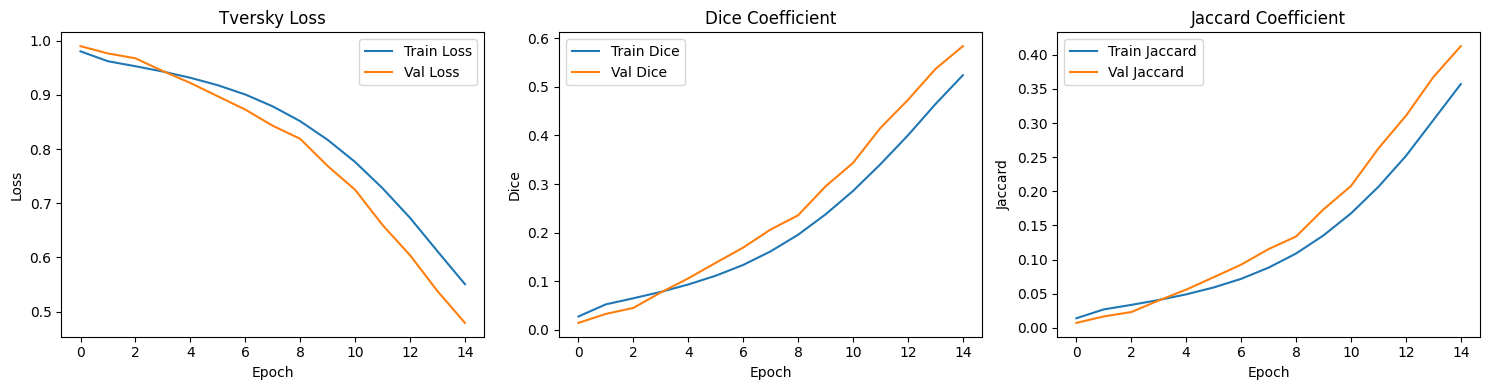

In [33]:
plot_training_curves(history)


In [34]:
def load_nifti(path):
    return nib.load(path).get_fdata()

def normalize_image(img, eps=1e-8):
    return (img - np.mean(img)) / (np.std(img) + eps)


def make_test_dataset(img_dir="dataset_cropped/test/images", lbl_dir="dataset_cropped/test/labels"):
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.nii")))
    lbl_paths = sorted(glob.glob(os.path.join(lbl_dir, "*.nii")))
    pairs = [(i,l) for i,l in zip(img_paths, lbl_paths) if os.path.exists(l)]
    return pairs


In [35]:
def test_and_save(model, test_pairs, out_dir="generated", threshold=0.5):
    os.makedirs(out_dir, exist_ok=True)
    dice_scores, jaccard_scores = [], []

    for img_path, lbl_path in test_pairs:
        sid = os.path.basename(img_path).split("_")[1].split(".")[0]

        # Load image/label volumes
        img = nib.load(img_path).get_fdata().astype(np.float32)
        lbl_nii = nib.load(lbl_path)
        lbl = lbl_nii.get_fdata().astype(np.float32)
        lbl = (lbl > 0.5).astype(np.float32)

        # Normalize image
        img = (img - img.mean()) / (img.std() + 1e-8)

        # Predict
        img_in = img[np.newaxis, ..., np.newaxis]         # (1,D,H,W,1)
        pred = model.predict(img_in, verbose=0)[0, ..., 0]
        pred_bin = (pred > threshold).astype(np.float32)

        # Metrics (NumPy)
        dice = dice_coef_np(lbl, pred_bin)
        jaccard = jaccard_coef_np(lbl, pred_bin)
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)

        # Save prediction with the SAME affine+header as the GT label
        pred_nii = nib.Nifti1Image(pred_bin.astype(np.uint8),
                                   affine=lbl_nii.affine,
                                   header=lbl_nii.header)
        nib.save(pred_nii, os.path.join(out_dir, f"{sid}_pred.nii"))

        mid = img.shape[2] // 2
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(img[:, :, mid], cmap="gray")
        plt.imshow(lbl[:, :, mid], alpha=0.4, cmap="Reds")
        plt.title(f"GT {sid}"); plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(img[:, :, mid], cmap="gray")
        plt.imshow(pred_bin[:, :, mid], alpha=0.4, cmap="Oranges")
        plt.title(f"Pred {sid} (Dice {dice:.3f}, IoU {jaccard:.3f})"); plt.axis("off")
        plt.show()

    print(f"✔ Test Results on {len(test_pairs)} subjects")
    print(f"Mean Dice:    {np.mean(dice_scores):.4f}")
    print(f"Mean Jaccard: {np.mean(jaccard_scores):.4f}")


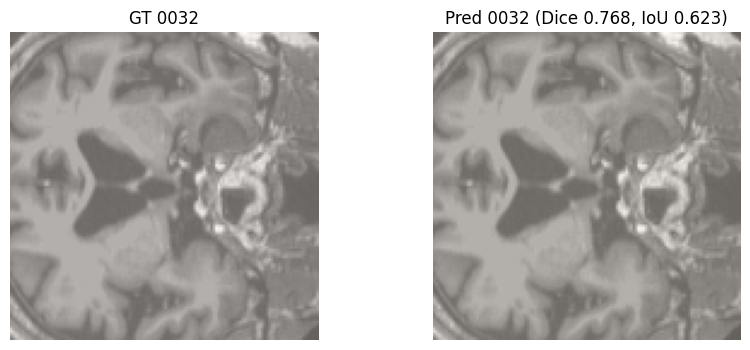

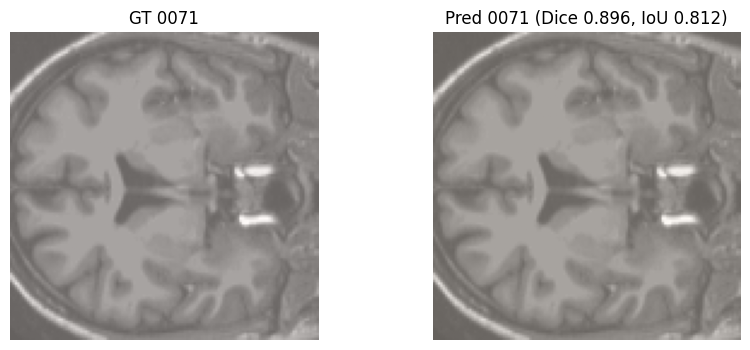

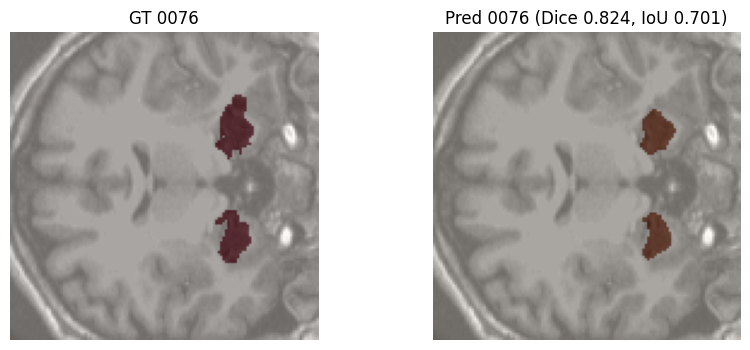

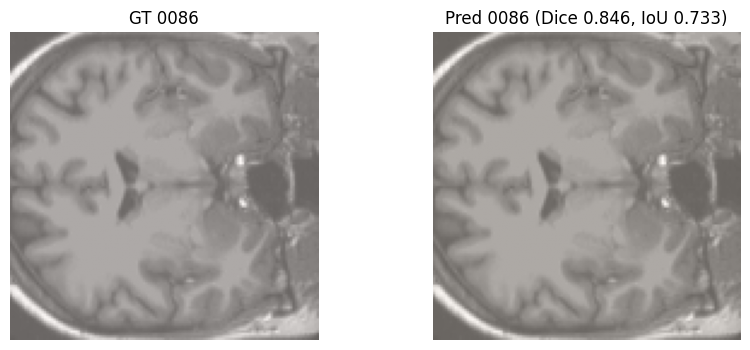

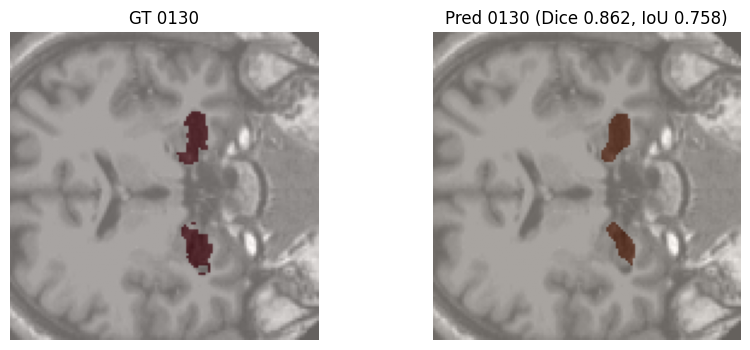

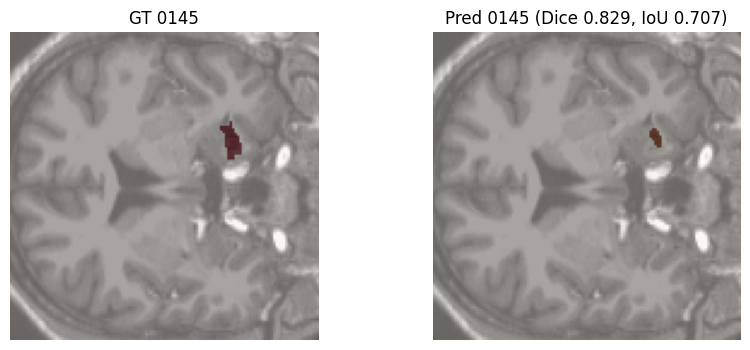

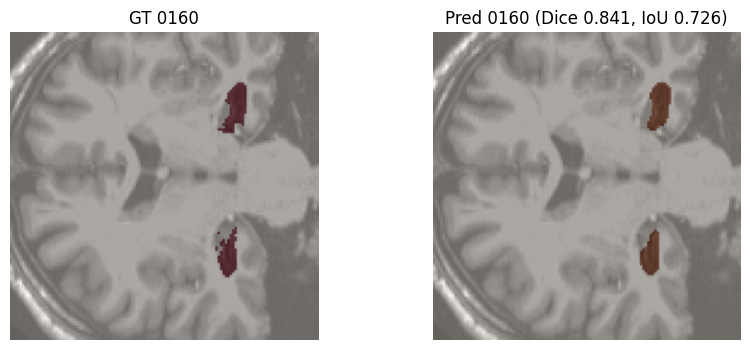

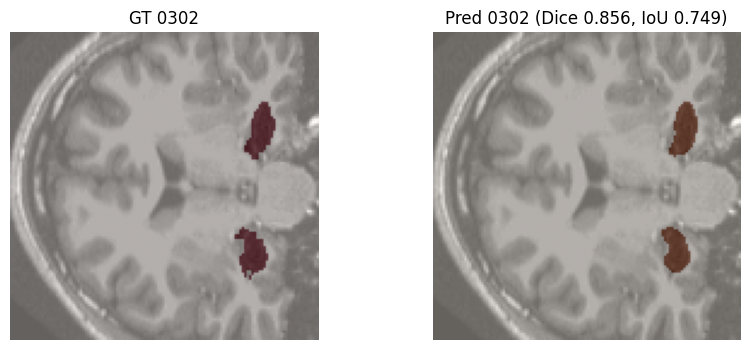

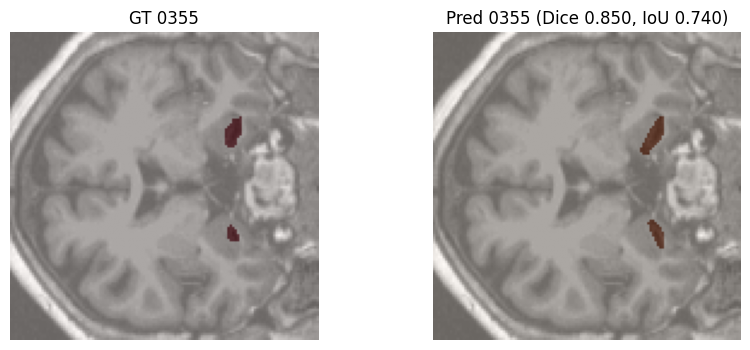

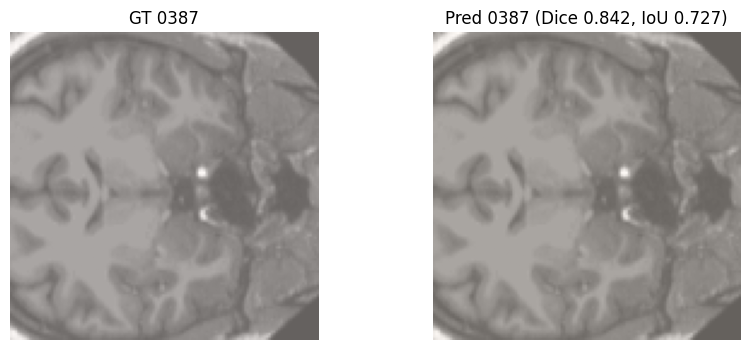

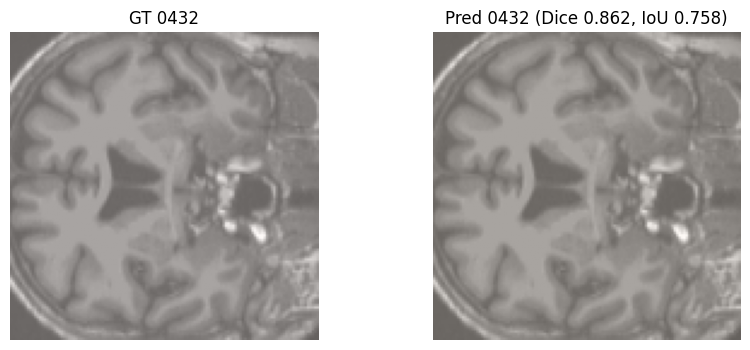

✔ Test Results on 11 subjects
Mean Dice:    0.8434
Mean Jaccard: 0.7303


In [36]:
test_pairs = make_test_dataset("/content/Final_tvt_Dataset/test/images", "/content/Final_tvt_Dataset/test/labels")
test_and_save(model, test_pairs, out_dir="generated_cropped")


In [ ]:
gt_path = "dataset_cropped/test/labels/0001.nii"
pred_path = "/content/generated_cropped/0001_pred.nii"


gt_img = nib.load(gt_path)
pred_img = nib.load(pred_path)


print("GT shape:   ", gt_img.shape)
print("Pred shape: ", pred_img.shape)


print("GT affine:\n", gt_img.affine)
print("Pred affine:\n", pred_img.affine)

same_affine = np.allclose(gt_img.affine, pred_img.affine, atol=1e-4)
print("Affine match?:", same_affine)


GT shape:    (128, 128, 128)
Pred shape:  (128, 128, 128)
GT affine:
 [[ -1.  -0.  -0.  64.]
 [ -0.   0.   1. -64.]
 [  0.  -1.   0.  64.]
 [  0.   0.   0.   1.]]
Pred affine:
 [[ -1.  -0.  -0.  64.]
 [ -0.   0.   1. -64.]
 [  0.  -1.   0.  64.]
 [  0.   0.   0.   1.]]
Affine match?: True


In [37]:
from google.colab import files
import shutil

def zip_and_download(folder_path, zip_name=None):
    if zip_name is None:
        zip_name = folder_path.rstrip("/")


    shutil.make_archive(zip_name, 'zip', folder_path)
    files.download(f"{zip_name}.zip")


zip_and_download("Final_tvt_Dataset", zip_name="Final_tvt_Dataset")
zip_and_download("generated_cropped", zip_name="final_generated")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
zip_and_download("generated_cropped", zip_name="final_generated")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
files.download("best_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
zip_and_download("dataset_cropped", zip_name="dataset_cropped")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>